# Phase 2: 数据可视化 (Data Visualization)

## 概述 Overview

本Notebook实现Phase 2的数据探索性分析，从两个维度分析数据特征：

**分析维度：**
1. **专利内分析**: 比较同一数据集中单体vs二聚体的稳定性差异
2. **专利间分析**: 比较不同数据集的特征分布和标签差异

**可视化内容：**
- 降维可视化 (PCA, t-SNE)
- 稳定性分布对比 (直方图, 小提琴图, 箱线图)
- 结构特征对比 (环化率, 二硫键含量)
- 统计检验 (Mann-Whitney U, Kruskal-Wallis)

**输入**: 
- `data/processed/*.csv` - 带分子特征的CSV  
- `outputs/features/*.npz` - RDKit特征矩阵  

**输出**: 
- `outputs/figures/phase2/within_patent/` - 专利内可视化  
- `outputs/figures/phase2/between_patents/` - 专利间可视化  
- `docs/dev/Phase2_数据可视化报告.md` - 分析报告  

---

## 1. 环境检查与导入 Environment Setup

In [1]:
# 环境检查
import sys
from pathlib import Path

# 添加项目根目录到路径
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# 核心库导入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# 统计和降维
from scipy.stats import mannwhitneyu, kruskal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ 所有库已成功导入")
print(f"✓ 项目根目录: {project_root}")

✓ 所有库已成功导入
✓ 项目根目录: d:\RA\feature_extraction


## 2. 参数配置区 Configuration

**⚙️ 根据您的需求修改以下参数**

In [2]:
# ============== 参数配置区 ==============

CONFIG = {
    # 输入输出路径
    'processed_dir': project_root / 'data' / 'processed',
    'features_dir': project_root / 'outputs' / 'features',
    'within_patent_dir': project_root / 'outputs' / 'figures' / 'phase2' / 'within_patent',
    'between_patent_dir': project_root / 'outputs' / 'figures' / 'phase2' / 'between_patents',
    'report_dir': project_root / 'docs' / 'dev',
    
    # 可视化参数
    'dpi': 300,
    'format': 'png',
    'display_plots': True,
    'max_display_plots': 5,
    
    # 降维参数
    'pca_components': 2,
    'tsne_components': 2,
    'tsne_perplexity': 30,
    'tsne_random_state': 42,
}

# 创建输出目录
CONFIG['within_patent_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['between_patent_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['report_dir'].mkdir(parents=True, exist_ok=True)

print("配置参数:")
for key, value in CONFIG.items():
    if isinstance(value, Path):
        print(f"  {key}: {value.relative_to(project_root) if value.is_relative_to(project_root) else value}")
    else:
        print(f"  {key}: {value}")

配置参数:
  processed_dir: data\processed
  features_dir: outputs\features
  within_patent_dir: outputs\figures\phase2\within_patent
  between_patent_dir: outputs\figures\phase2\between_patents
  report_dir: docs\dev
  dpi: 300
  format: png
  display_plots: True
  max_display_plots: 5
  pca_components: 2
  tsne_components: 2
  tsne_perplexity: 30
  tsne_random_state: 42


## 3. 专利内分析 Within-Patent Analysis

比较同一数据集中**单体 vs 二聚体**的稳定性差异

找到 5 个处理后的CSV文件

sif_sgf_second:
  单体样本: 202
  二聚体样本: 356
  ✓ SIF对比图: sif_sgf_second_sif_monomer_dimer_comparison.png


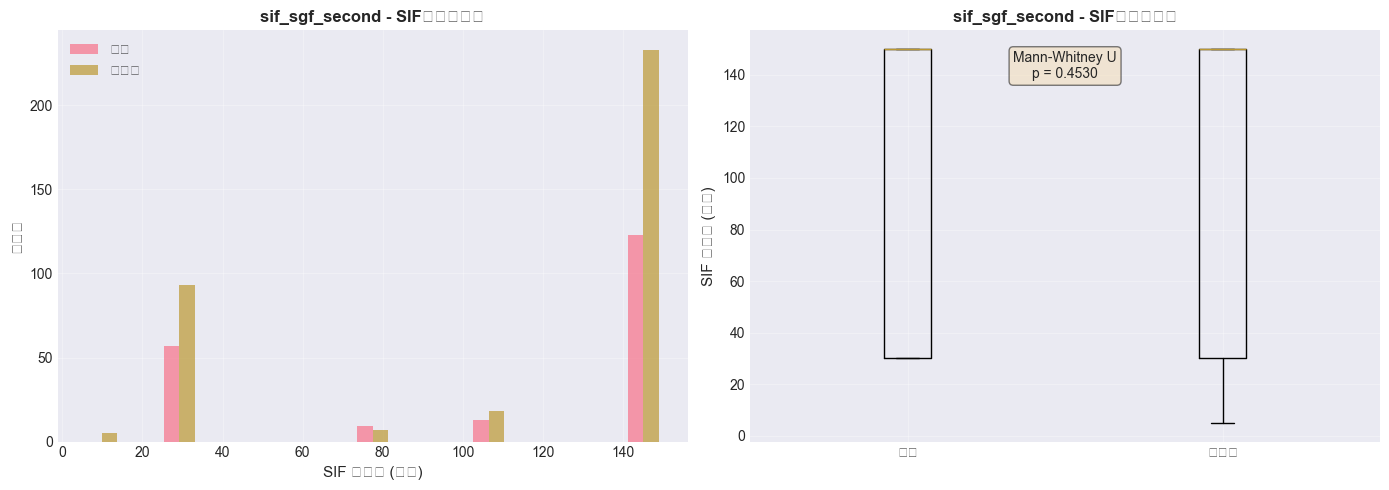

  ✓ SGF对比图: sif_sgf_second_sgf_monomer_dimer_comparison.png


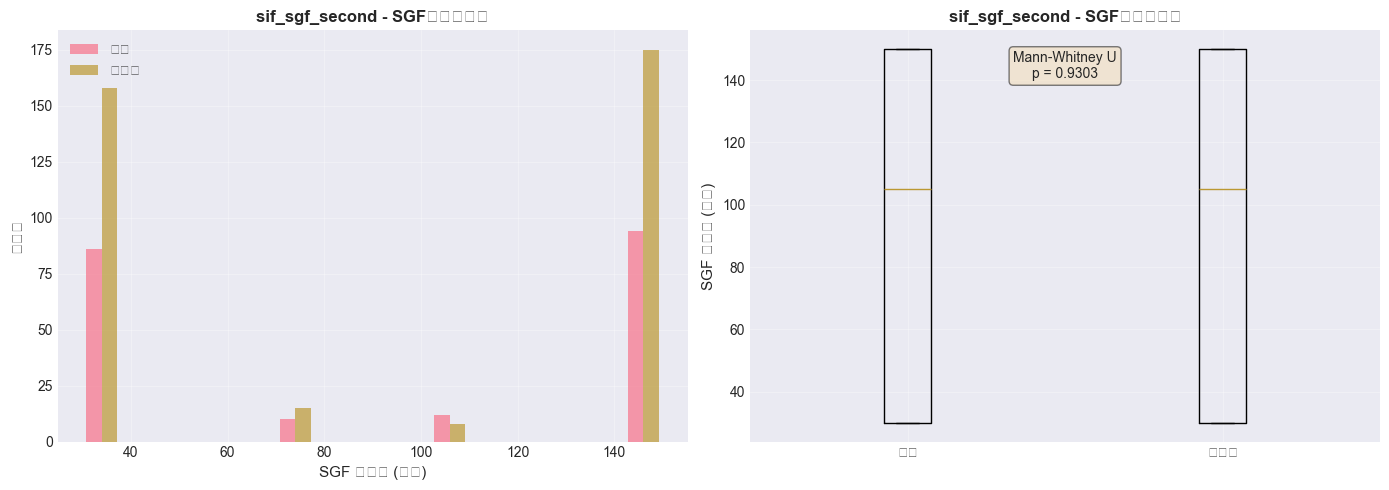

  ✓ 结构特征图: sif_sgf_second_structural_features_comparison.png


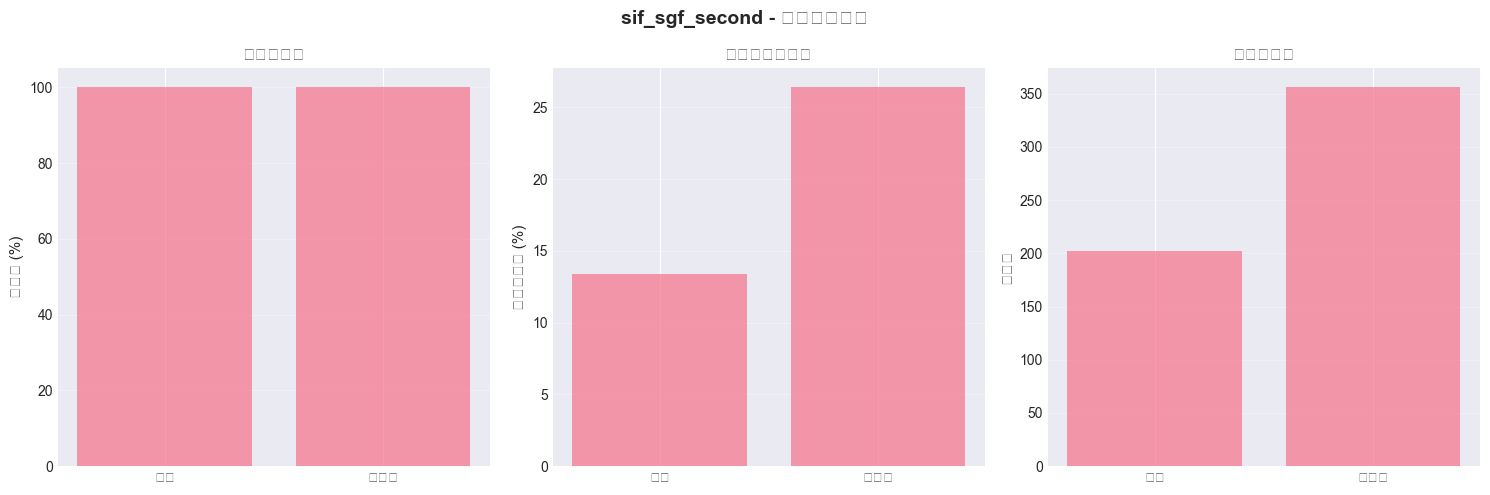

  ✓ 统计摘要: sif_sgf_second_statistical_summary.json

US20140294902A1:
  单体样本: 5
  二聚体样本: 0
  ✓ 结构特征图: US20140294902A1_structural_features_comparison.png


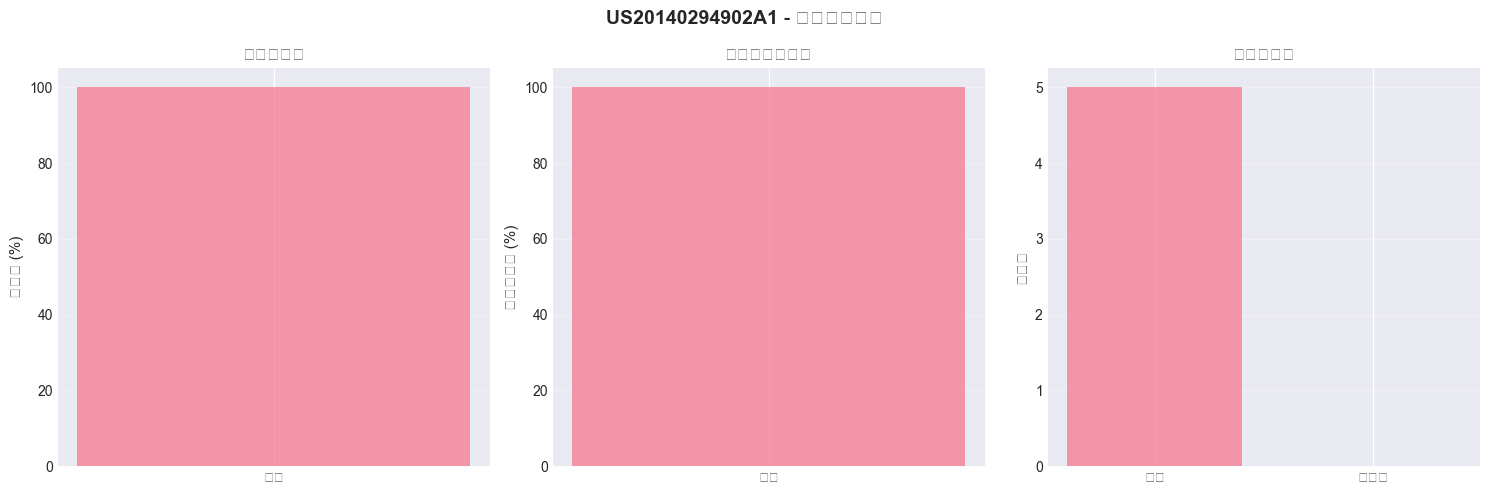

  ✓ 统计摘要: US20140294902A1_statistical_summary.json

US9624268:
  单体样本: 130
  二聚体样本: 0
  ✓ 结构特征图: US9624268_structural_features_comparison.png


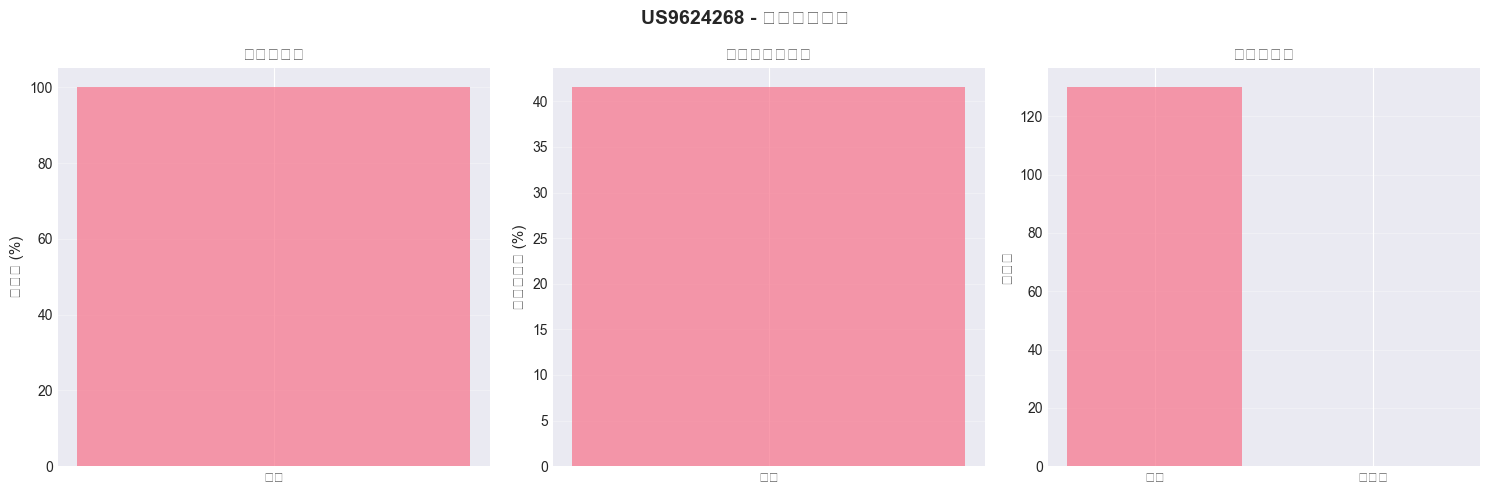

  ✓ 统计摘要: US9624268_statistical_summary.json

US9809623B2:
  单体样本: 32
  二聚体样本: 48
  ✓ SIF对比图: US9809623B2_sif_monomer_dimer_comparison.png


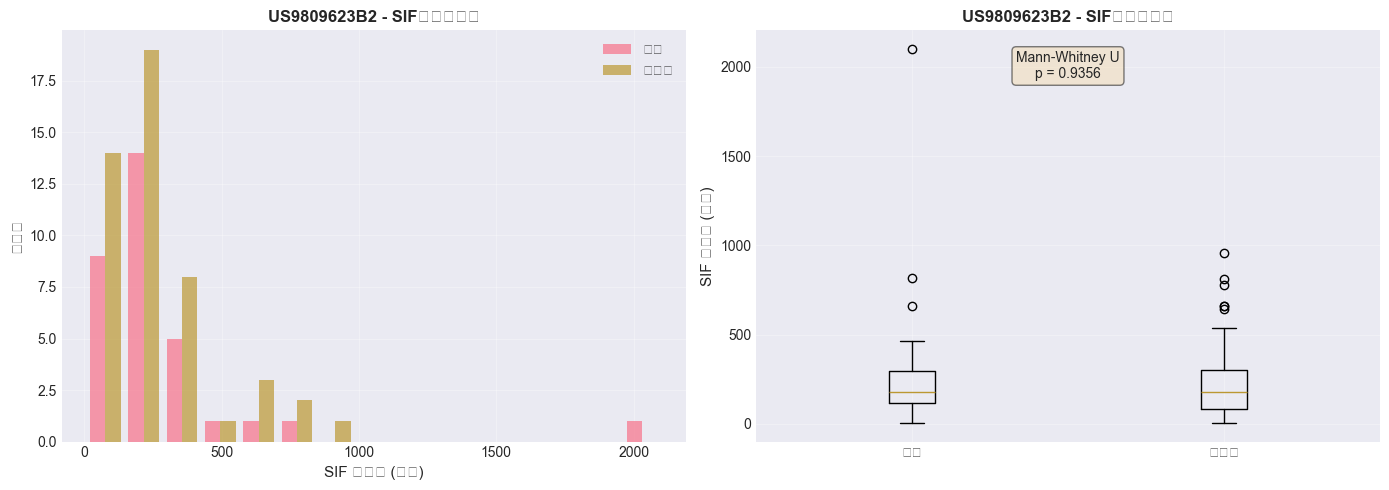

  ✓ SGF对比图: US9809623B2_sgf_monomer_dimer_comparison.png


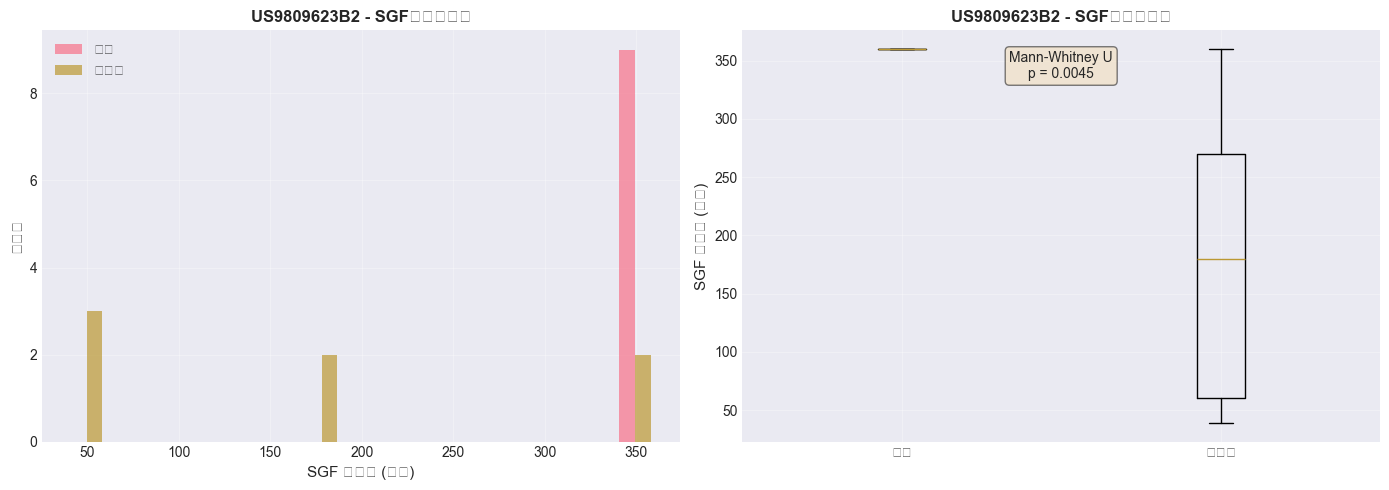

  ✓ 结构特征图: US9809623B2_structural_features_comparison.png


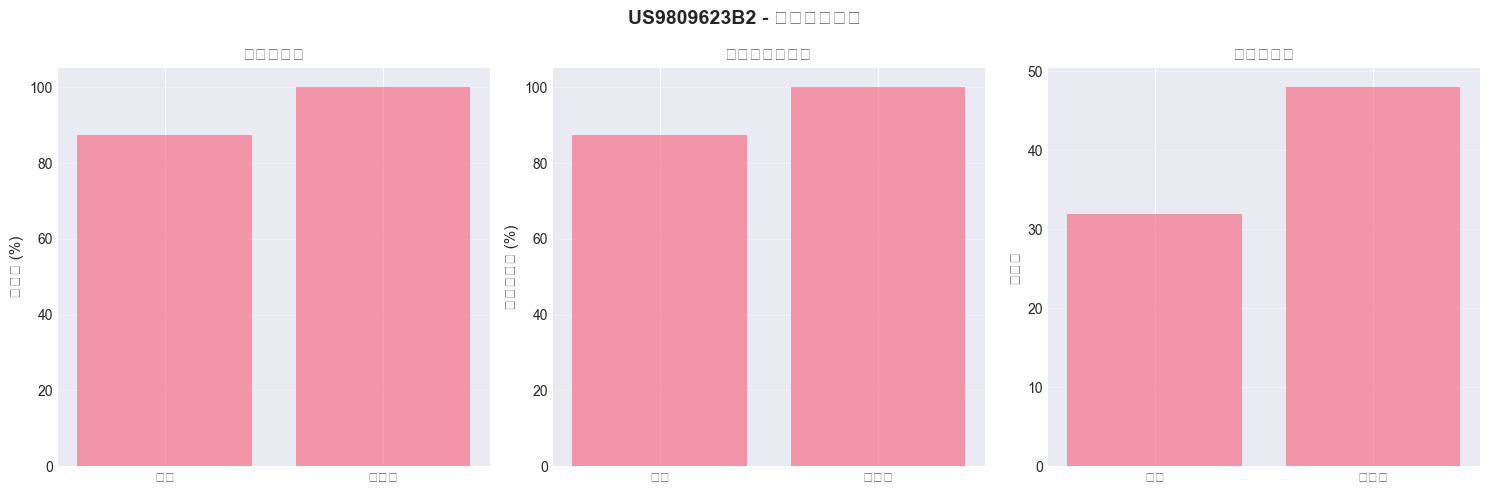

  ✓ 统计摘要: US9809623B2_statistical_summary.json

WO2017011820A2:
  单体样本: 151
  二聚体样本: 8
  ✓ SIF对比图: WO2017011820A2_sif_monomer_dimer_comparison.png


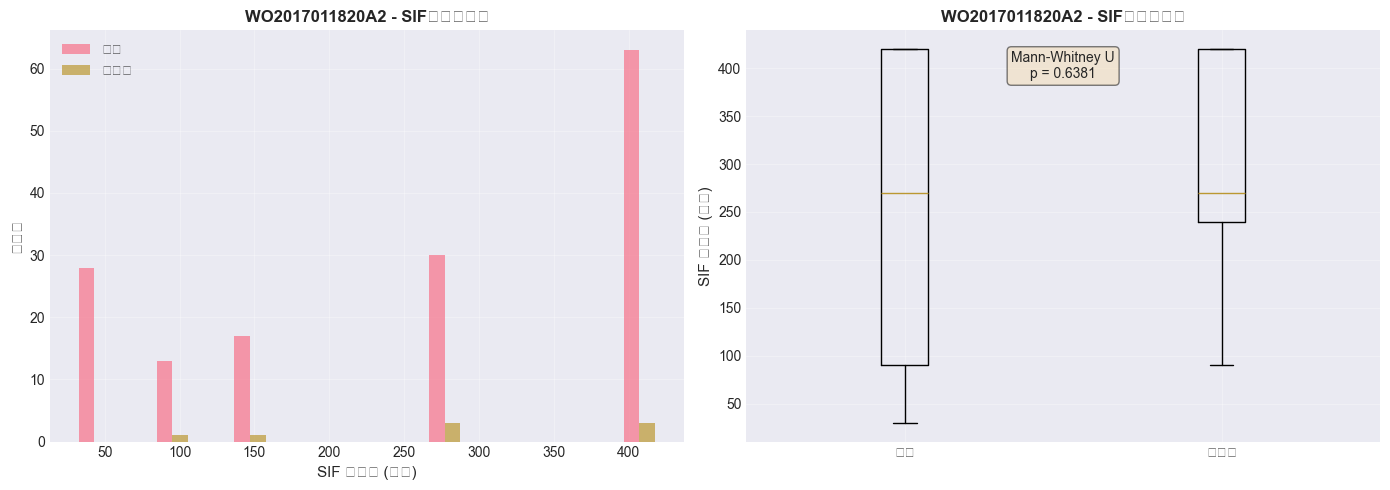

  ✓ SGF对比图: WO2017011820A2_sgf_monomer_dimer_comparison.png


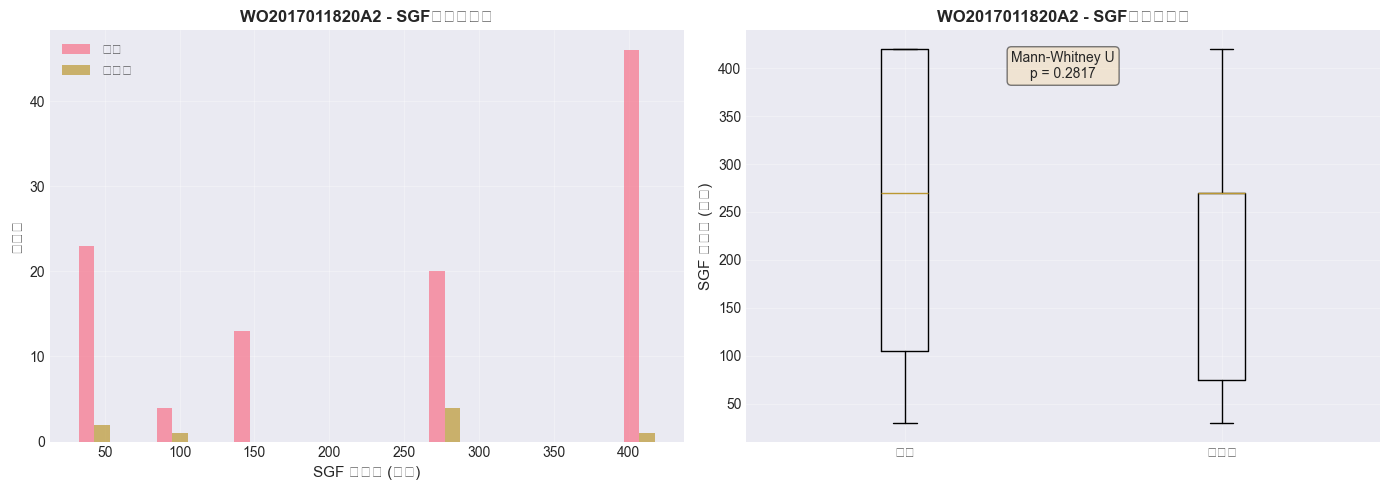

  ✓ 结构特征图: WO2017011820A2_structural_features_comparison.png


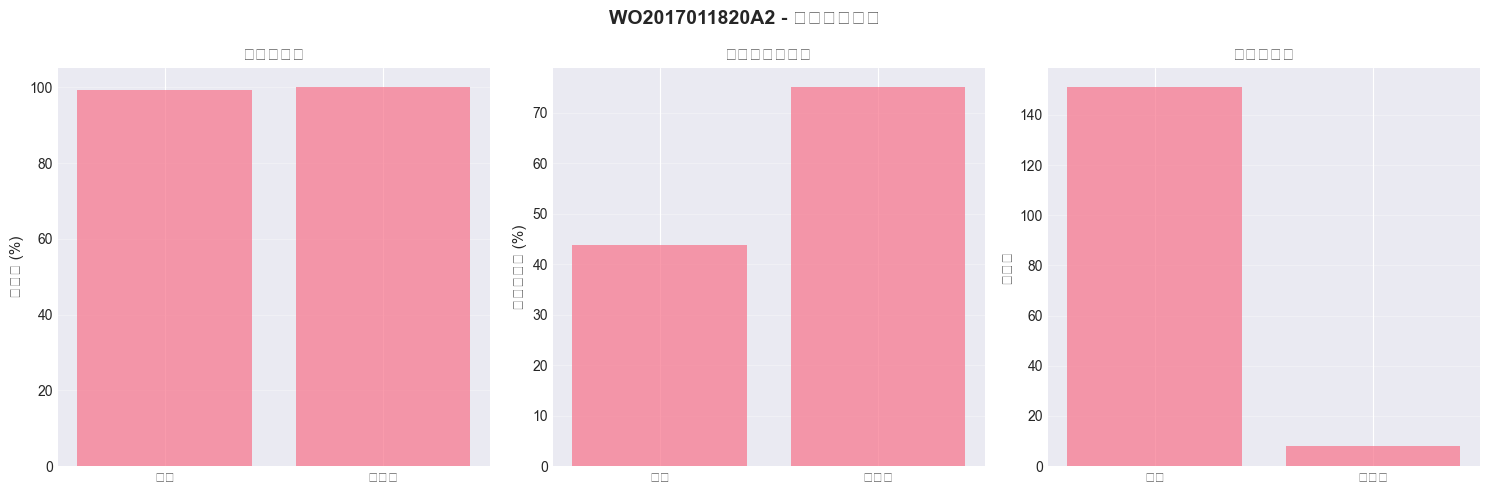

  ✓ 统计摘要: WO2017011820A2_statistical_summary.json

✓ 专利内分析完成！
  输出目录: outputs\figures\phase2\within_patent


In [3]:
def plot_within_patent_analysis(csv_path: Path, output_dir: Path):
    """
    专利内分析：单体vs二聚体对比
    
    Args:
        csv_path: 处理后的CSV文件
        output_dir: 输出目录
    """
    # 加载数据
    df = pd.read_csv(csv_path)
    dataset_name = csv_path.stem.replace('_processed', '')
    
    # 创建数据集专属目录
    dataset_dir = output_dir / dataset_name
    dataset_dir.mkdir(exist_ok=True)
    
    # 分离单体和二聚体
    monomer_df = df[df['is_dimer'] == 0]
    dimer_df = df[df['is_dimer'] == 1]
    
    print(f"\n{dataset_name}:")
    print(f"  单体样本: {len(monomer_df)}")
    print(f"  二聚体样本: {len(dimer_df)}")
    
    # 统计检验
    stats = {}
    
    # 1. SIF稳定性分布对比
    if len(monomer_df) > 0 and len(dimer_df) > 0:
        sif_mono = monomer_df[monomer_df['SIF_minutes'] != -1]['SIF_minutes']
        sif_dimer = dimer_df[dimer_df['SIF_minutes'] != -1]['SIF_minutes']
        
        if len(sif_mono) > 0 and len(sif_dimer) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # 直方图
            axes[0].hist([sif_mono, sif_dimer], bins=15, label=['单体', '二聚体'], alpha=0.7)
            axes[0].set_xlabel('SIF 半衰期 (分钟)', fontsize=11)
            axes[0].set_ylabel('样本数', fontsize=11)
            axes[0].set_title(f'{dataset_name} - SIF稳定性分布', fontsize=12, fontweight='bold')
            axes[0].legend()
            axes[0].grid(alpha=0.3)
            
            # 箱线图
            data_to_plot = [sif_mono, sif_dimer]
            axes[1].boxplot(data_to_plot, labels=['单体', '二聚体'])
            axes[1].set_ylabel('SIF 半衰期 (分钟)', fontsize=11)
            axes[1].set_title(f'{dataset_name} - SIF稳定性对比', fontsize=12, fontweight='bold')
            axes[1].grid(alpha=0.3)
            
            # Mann-Whitney U检验
            stat, pval = mannwhitneyu(sif_mono, sif_dimer, alternative='two-sided')
            axes[1].text(0.5, 0.95, f'Mann-Whitney U\np = {pval:.4f}', 
                        transform=axes[1].transAxes, ha='center', va='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plot_path = dataset_dir / f'{dataset_name}_sif_monomer_dimer_comparison.png'
            plt.savefig(plot_path, dpi=CONFIG['dpi'], bbox_inches='tight')
            print(f"  ✓ SIF对比图: {plot_path.name}")
            
            if CONFIG['display_plots']:
                plt.show()
            else:
                plt.close()
            
            stats['sif_pvalue'] = float(pval)
            stats['sif_significant'] = pval < 0.05
        
        # 2. SGF稳定性分布对比（同样的逻辑）
        sgf_mono = monomer_df[monomer_df['SGF_minutes'] != -1]['SGF_minutes']
        sgf_dimer = dimer_df[dimer_df['SGF_minutes'] != -1]['SGF_minutes']
        
        if len(sgf_mono) > 0 and len(sgf_dimer) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            axes[0].hist([sgf_mono, sgf_dimer], bins=15, label=['单体', '二聚体'], alpha=0.7)
            axes[0].set_xlabel('SGF 半衰期 (分钟)', fontsize=11)
            axes[0].set_ylabel('样本数', fontsize=11)
            axes[0].set_title(f'{dataset_name} - SGF稳定性分布', fontsize=12, fontweight='bold')
            axes[0].legend()
            axes[0].grid(alpha=0.3)
            
            data_to_plot = [sgf_mono, sgf_dimer]
            axes[1].boxplot(data_to_plot, labels=['单体', '二聚体'])
            axes[1].set_ylabel('SGF 半衰期 (分钟)', fontsize=11)
            axes[1].set_title(f'{dataset_name} - SGF稳定性对比', fontsize=12, fontweight='bold')
            axes[1].grid(alpha=0.3)
            
            stat, pval = mannwhitneyu(sgf_mono, sgf_dimer, alternative='two-sided')
            axes[1].text(0.5, 0.95, f'Mann-Whitney U\np = {pval:.4f}', 
                        transform=axes[1].transAxes, ha='center', va='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plot_path = dataset_dir / f'{dataset_name}_sgf_monomer_dimer_comparison.png'
            plt.savefig(plot_path, dpi=CONFIG['dpi'], bbox_inches='tight')
            print(f"  ✓ SGF对比图: {plot_path.name}")
            
            if CONFIG['display_plots']:
                plt.show()
            else:
                plt.close()
            
            stats['sgf_pvalue'] = float(pval)
            stats['sgf_significant'] = pval < 0.05
    
    # 3. 结构特征对比
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 环化率
    mono_cyclic_pct = monomer_df['is_cyclic'].mean() * 100
    dimer_cyclic_pct = dimer_df['is_cyclic'].mean() * 100
    axes[0].bar(['单体', '二聚体'], [mono_cyclic_pct, dimer_cyclic_pct], alpha=0.7)
    axes[0].set_ylabel('环化率 (%)', fontsize=11)
    axes[0].set_title('环化率对比', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 二硫键含量
    mono_disulf_pct = monomer_df['has_disulfide_bond'].mean() * 100
    dimer_disulf_pct = dimer_df['has_disulfide_bond'].mean() * 100
    axes[1].bar(['单体', '二聚体'], [mono_disulf_pct, dimer_disulf_pct], alpha=0.7)
    axes[1].set_ylabel('二硫键含量 (%)', fontsize=11)
    axes[1].set_title('二硫键含量对比', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    
    # 样本数对比
    axes[2].bar(['单体', '二聚体'], [len(monomer_df), len(dimer_df)], alpha=0.7)
    axes[2].set_ylabel('样本数', fontsize=11)
    axes[2].set_title('样本数对比', fontsize=12)
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'{dataset_name} - 结构特征对比', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    plot_path = dataset_dir / f'{dataset_name}_structural_features_comparison.png'
    plt.savefig(plot_path, dpi=CONFIG['dpi'], bbox_inches='tight')
    print(f"  ✓ 结构特征图: {plot_path.name}")
    
    if CONFIG['display_plots']:
        plt.show()
    else:
        plt.close()
    
    # 保存统计摘要
    stats_path = dataset_dir / f'{dataset_name}_statistical_summary.json'
    with open(stats_path, 'w') as f:
        # 转换numpy类型为Python原生类型
        stats = {k: (int(v) if isinstance(v, (np.integer, np.bool_)) else float(v) if isinstance(v, np.floating) else bool(v) if isinstance(v, np.bool_) else v) for k, v in stats.items()}
        json.dump(stats, f, indent=2)
    print(f"  ✓ 统计摘要: {stats_path.name}")
    
    return stats

# 执行：批量分析所有数据集
processed_csvs = list(CONFIG['processed_dir'].glob('*_processed.csv'))
print(f"找到 {len(processed_csvs)} 个处理后的CSV文件")

all_within_stats = {}
for csv_file in processed_csvs:
    stats = plot_within_patent_analysis(csv_file, CONFIG['within_patent_dir'])
    all_within_stats[csv_file.stem.replace('_processed', '')] = stats

print(f"\n✓ 专利内分析完成！")
print(f"  输出目录: {CONFIG['within_patent_dir'].relative_to(project_root)}")

## 4. 专利间分析 Between-Patents Analysis

比较不同数据集的特征分布和标签差异

In [4]:
# 4.1 加载所有数据集的特征
def load_all_data():
    """
    加载所有数据集的特征和标签
    """
    all_features = []
    all_sif_labels = []
    all_sgf_labels = []
    all_dataset_labels = []
    dataset_names = []
    
    npz_files = list(CONFIG['features_dir'].glob('*_processed.npz'))
    
    for npz_file in sorted(npz_files):
        data = np.load(npz_file, allow_pickle=True)
        dataset_name = npz_file.stem.replace('_processed', '')
        
        X = data['X']
        y_sif = data['y_sif']
        y_sgf = data['y_sgf']
        
        all_features.append(X)
        all_sif_labels.extend(y_sif)
        all_sgf_labels.extend(y_sgf)
        all_dataset_labels.extend([dataset_name] * len(X))
        dataset_names.append(dataset_name)
        
        print(f"  加载 {dataset_name}: {len(X)} samples")
    
    all_features = np.vstack(all_features)
    all_sif_labels = np.array(all_sif_labels)
    all_sgf_labels = np.array(all_sgf_labels)
    all_dataset_labels = np.array(all_dataset_labels)
    
    return all_features, all_sif_labels, all_sgf_labels, all_dataset_labels, dataset_names

print("加载所有数据集...")
X_all, y_sif_all, y_sgf_all, dataset_labels, dataset_names = load_all_data()

print(f"\n总样本数: {len(X_all)}")
print(f"特征维度: {X_all.shape[1]}")
print(f"数据集数量: {len(dataset_names)}")

加载所有数据集...
  加载 sif_sgf_second: 558 samples
  加载 US20140294902A1: 5 samples
  加载 US9624268: 130 samples
  加载 US9809623B2: 76 samples
  加载 WO2017011820A2: 158 samples

总样本数: 927
特征维度: 1048
数据集数量: 5



执行PCA降维...
✓ 已保存: pca_2d_by_dataset.png


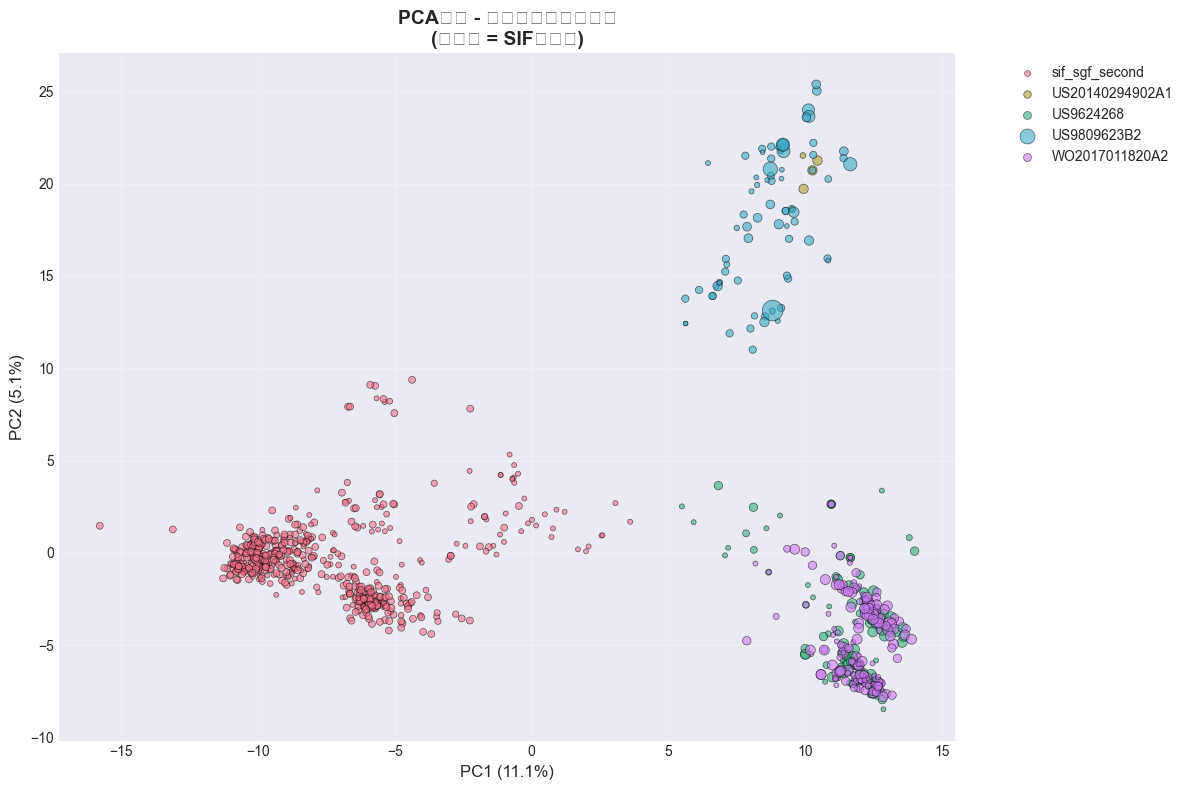

In [5]:
# 4.2 降维可视化: PCA
print("\n执行PCA降维...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

pca = PCA(n_components=CONFIG['pca_components'])
X_pca = pca.fit_transform(X_scaled)

# 绘制PCA图（点大小=SIF半衰期，颜色=数据集）
fig, ax = plt.subplots(figsize=(12, 8))

# 为每个数据集分配颜色
colors = sns.color_palette("husl", len(dataset_names))
for i, dataset in enumerate(dataset_names):
    mask = dataset_labels == dataset
    sif_sizes = y_sif_all[mask]
    # 将-1转为最小值，用于可视化
    sif_sizes_plot = np.where(sif_sizes == -1, 10, sif_sizes / 10 + 10)
    
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              s=sif_sizes_plot, c=[colors[i]], 
              label=dataset, alpha=0.6, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('PCA降维 - 不同数据集特征分布\n(点大小 = SIF半衰期)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
pca_path = CONFIG['between_patent_dir'] / 'pca_2d_by_dataset.png'
plt.savefig(pca_path, dpi=CONFIG['dpi'], bbox_inches='tight')
print(f"✓ 已保存: {pca_path.name}")

if CONFIG['display_plots']:
    plt.show()
else:
    plt.close()


执行t-SNE降维（可能需要几分钟）...


✓ 已保存: tsne_2d_by_dataset.png


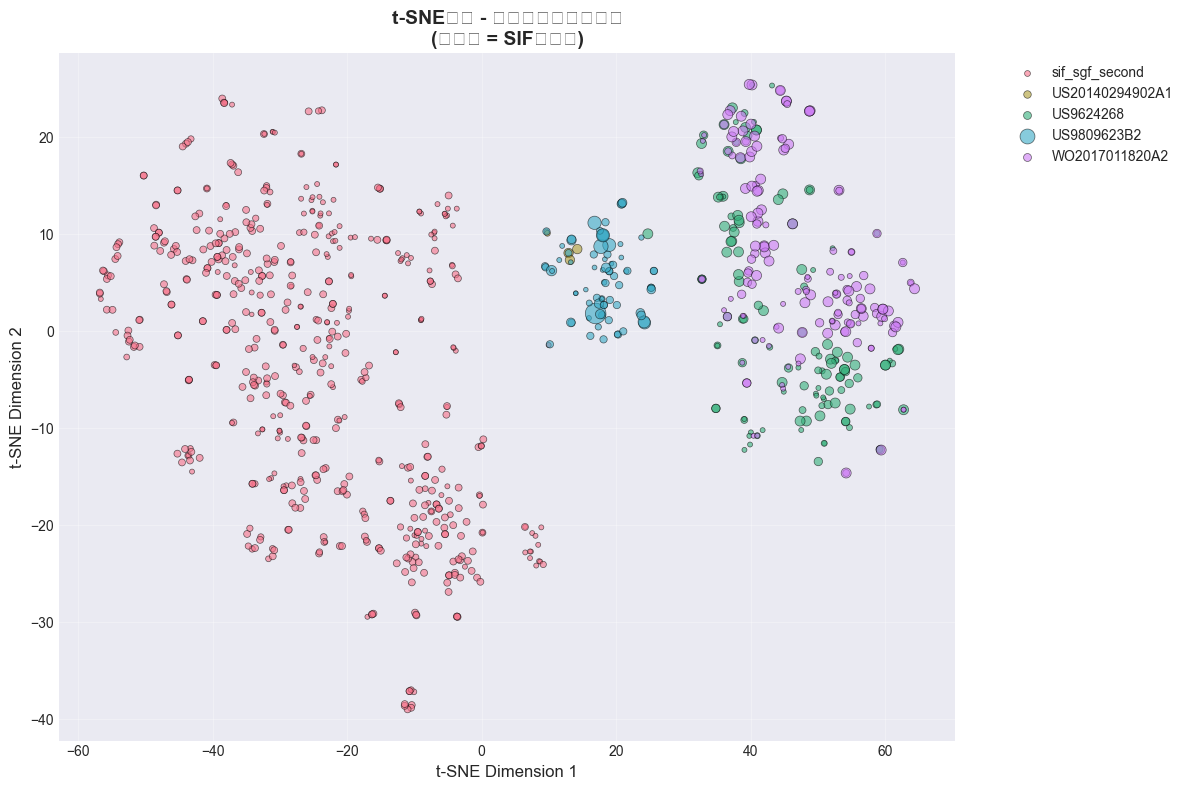

In [6]:
# 4.3 降维可视化: t-SNE
print("\n执行t-SNE降维（可能需要几分钟）...")
tsne = TSNE(
    n_components=CONFIG['tsne_components'],
    perplexity=CONFIG['tsne_perplexity'],
    random_state=CONFIG['tsne_random_state']
)
X_tsne = tsne.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 8))

for i, dataset in enumerate(dataset_names):
    mask = dataset_labels == dataset
    sif_sizes = y_sif_all[mask]
    sif_sizes_plot = np.where(sif_sizes == -1, 10, sif_sizes / 10 + 10)
    
    ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
              s=sif_sizes_plot, c=[colors[i]], 
              label=dataset, alpha=0.6, edgecolors='k', linewidth=0.5)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('t-SNE降维 - 不同数据集特征分布\n(点大小 = SIF半衰期)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
tsne_path = CONFIG['between_patent_dir'] / 'tsne_2d_by_dataset.png'
plt.savefig(tsne_path, dpi=CONFIG['dpi'], bbox_inches='tight')
print(f"✓ 已保存: {tsne_path.name}")

if CONFIG['display_plots']:
    plt.show()
else:
    plt.close()

✓ 已保存: label_distribution_violin_plots.png


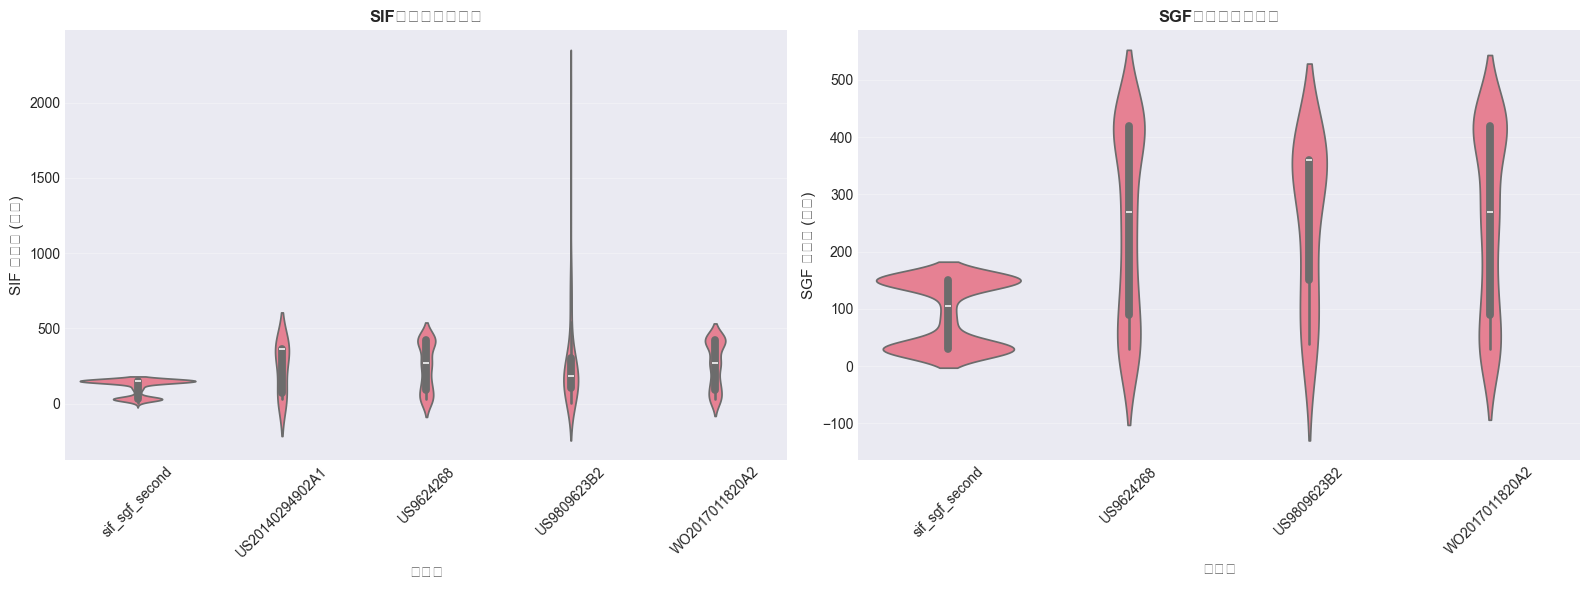


Kruskal-Wallis检验结果:
  SIF: H = 166.3089, p = 6.4797e-35 (显著)
  SGF: H = 154.9454, p = 2.2586e-33 (显著)


In [7]:
# 4.4 标签分布对比：小提琴图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 准备数据（过滤掉-1）
df_plot = pd.DataFrame({
    'Dataset': dataset_labels,
    'SIF': y_sif_all,
    'SGF': y_sgf_all
})

# SIF小提琴图
df_sif = df_plot[df_plot['SIF'] != -1]
sns.violinplot(data=df_sif, x='Dataset', y='SIF', ax=axes[0])
axes[0].set_xlabel('数据集', fontsize=11)
axes[0].set_ylabel('SIF 半衰期 (分钟)', fontsize=11)
axes[0].set_title('SIF稳定性分布对比', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# SGF小提琴图
df_sgf = df_plot[df_plot['SGF'] != -1]
sns.violinplot(data=df_sgf, x='Dataset', y='SGF', ax=axes[1])
axes[1].set_xlabel('数据集', fontsize=11)
axes[1].set_ylabel('SGF 半衰期 (分钟)', fontsize=11)
axes[1].set_title('SGF稳定性分布对比', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
violin_path = CONFIG['between_patent_dir'] / 'label_distribution_violin_plots.png'
plt.savefig(violin_path, dpi=CONFIG['dpi'], bbox_inches='tight')
print(f"✓ 已保存: {violin_path.name}")

if CONFIG['display_plots']:
    plt.show()
else:
    plt.close()

# Kruskal-Wallis检验
sif_groups = [df_sif[df_sif['Dataset'] == ds]['SIF'].values for ds in dataset_names]
sgf_groups = [df_sgf[df_sgf['Dataset'] == ds]['SGF'].values for ds in dataset_names]

sif_stat, sif_pval = kruskal(*[g for g in sif_groups if len(g) > 0])
sgf_stat, sgf_pval = kruskal(*[g for g in sgf_groups if len(g) > 0])

print(f"\nKruskal-Wallis检验结果:")
print(f"  SIF: H = {sif_stat:.4f}, p = {sif_pval:.4e} {'(显著)' if sif_pval < 0.05 else '(不显著)'}")
print(f"  SGF: H = {sgf_stat:.4f}, p = {sgf_pval:.4e} {'(显著)' if sgf_pval < 0.05 else '(不显著)'}")

## 5. 结果总结 Summary

In [8]:
print("="*70)
print("Phase 2: 数据可视化 - 执行完毕")
print("="*70)

print("\n📁 生成的文件:")

print(f"\n  1. 专利内可视化 ({len(list(CONFIG['within_patent_dir'].rglob('*.png')))} 个图表):")
for dataset_dir in sorted(CONFIG['within_patent_dir'].iterdir()):
    if dataset_dir.is_dir():
        n_plots = len(list(dataset_dir.glob('*.png')))
        print(f"     - {dataset_dir.name}: {n_plots} 个图表")

print(f"\n  2. 专利间可视化 ({len(list(CONFIG['between_patent_dir'].glob('*.png')))} 个图表):")
for f in sorted(CONFIG['between_patent_dir'].glob('*.png')):
    print(f"     - {f.name}")

print("\n📊 关键发现:")
print(f"  数据集异质性: {'显著' if sif_pval < 0.05 else '不显著'} (Kruskal-Wallis p={sif_pval:.4e})")
print(f"  总样本数: {len(X_all):,}")
print(f"  数据集数量: {len(dataset_names)}")

significant_within = sum(1 for stats in all_within_stats.values() if stats.get('sif_significant', False) or stats.get('sgf_significant', False))
print(f"  单体vs二聚体显著差异的数据集: {significant_within}/{len(all_within_stats)}")

print(f"\n✅ 下一步: 运行 Phase3_模型验证.ipynb")
print("="*70)

Phase 2: 数据可视化 - 执行完毕

📁 生成的文件:

  1. 专利内可视化 (20 个图表):
     - sif_sgf_second: 5 个图表
     - US20140294902A1: 2 个图表
     - US9624268: 3 个图表
     - US9809623B2: 5 个图表
     - WO2017011820A2: 5 个图表

  2. 专利间可视化 (9 个图表):
     - boxplot_comparison.png
     - dataset_statistics_comparison.png
     - label_distribution_violin_plots.png
     - pca_2d_by_dataset.png
     - pca_2d_by_patent.png
     - tsne_2d_by_dataset.png
     - tsne_2d_by_patent.png
     - violin_plot_sgf.png
     - violin_plot_sif.png

📊 关键发现:
  数据集异质性: 显著 (Kruskal-Wallis p=6.4797e-35)
  总样本数: 927
  数据集数量: 5
  单体vs二聚体显著差异的数据集: 1/5

✅ 下一步: 运行 Phase3_模型验证.ipynb
